In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import glob

from KITTI_dataset import kitti_dataset,KITTI_collate_fn
import torch 
from detector_models import resnet_backbone,BiFPN
from pillar_models import Pillar_Network_SECOND
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

xyz_range = np.array([0,-40.32,-2,80.64,40.32,3])
xy_voxel_size= np.array([0.16,0.16])
points_per_pillar = 100
n_pillars=12000

dataset = kitti_dataset()
dataloader = DataLoader(dataset,batch_size=2,collate_fn =KITTI_collate_fn)

In [2]:
img,(pillars, coord, contains_pillars),(pillar_img_pts,rgb_coors,contains_rgb),outputs = dataset[0]

In [3]:
from tqdm.notebook import tqdm
boxes = []
range_l = (xyz_range[3]-xyz_range[0]) #l
range_w = (xyz_range[4]-xyz_range[1]) #w
range_h = (xyz_range[5]-xyz_range[2]) #h


for img,(pillars, coord, contains_pillars),(pillar_img_pts,rgb_coors,contains_rgb),outputs in tqdm(dataset):
    box = (outputs["boxes"][...,3:6]*np.array([[range_l,range_w,range_h]])).cpu().numpy().astype(np.float32)
    boxes.append(box)

  0%|          | 0/7000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
stacked_boxes = np.vstack(boxes)
df = pd.DataFrame({"length":stacked_boxes[:,0],"width":stacked_boxes[:,1],"height":stacked_boxes[:,2]})

In [5]:
import seaborn as sns
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.preprocessing import MinMaxScaler
N_anchors = 1
N_scales = 3

In [6]:
X = df[["length","width","height"]].values.reshape(-1,3)

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
kmeans = KMeans(n_clusters=N_anchors*N_scales,max_iter=2000,algorithm="full").fit(X)

# kmeans = SpectralClustering(n_clusters=N_anchors*N_scales).fit(X)
X = scaler.inverse_transform(X)

In [7]:
X.shape

(2147, 3)

In [8]:
cluster_centers = kmeans.cluster_centers_
cluster_centers.sort(axis=0)
print(cluster_centers.shape)
cluster_centers = scaler.inverse_transform(cluster_centers[::-1])
cluster_centers

(3, 3)


array([[9.351574  , 2.316415  , 2.951132  ],
       [3.9119163 , 1.6394603 , 1.7163126 ],
       [1.1359    , 0.64510316, 1.5540631 ]], dtype=float32)

In [10]:
clusters_dic = {"anchor_boxes":cluster_centers,"N_anchors":N_anchors,"N_scales":N_scales}
np.save("cluster_kitti_3scales_1anchor.npy",clusters_dic)

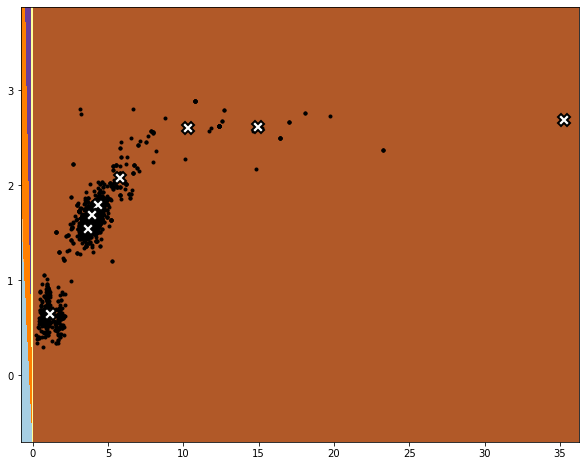

In [27]:
fig,ax = plt.subplots(1,1,figsize=(10,8))

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(scaler.inverse_transform(np.c_[xx.ravel(), yy.ravel(), np.ones_like(yy.ravel())].astype(np.float32)))

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# plt.clf()
ax.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)


ax.plot(X[:,0],X[:,1],".k")
ax.plot(cluster_centers[:,0],cluster_centers[:,1],"wX", markersize=12,markeredgewidth=2,markeredgecolor="k")
# ax.set_xlim([0,1.1])
# ax.set_ylim([0,1.1])
plt.show()

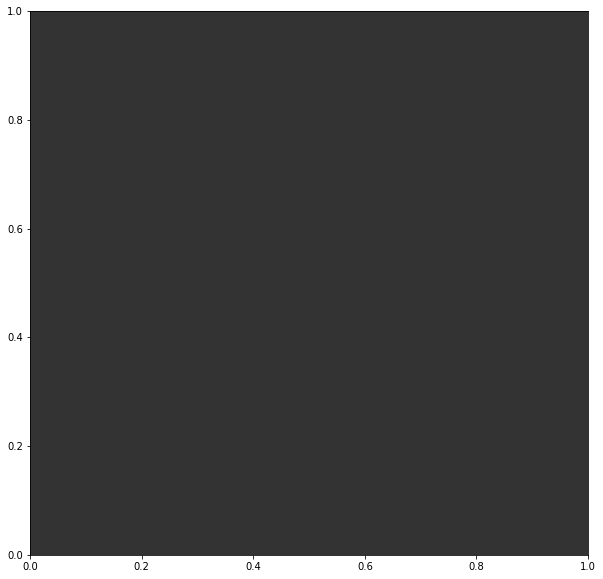

In [43]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

for (w,h),c in zip(cluster_centers[:,:2],plt.cm.Paired.colors):
    mx,my = 0-w/2,0-h/2
    rect = plt.Rectangle((mx,my),w,h,fill=False,color = c,linewidth=4)
    ax.add_artist(rect)
ax.set_facecolor((0.2,0.2,0.2))
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])
plt.show()

In [65]:
plt.cm.Paired.colors

((0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392))